begin reading file
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.600_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.600_x_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.600_x_2.h5
total event: 19965
preprocessing 0-th event
preprocessing 10000-th event


NameError: name 'main_Calib_photon' is not defined

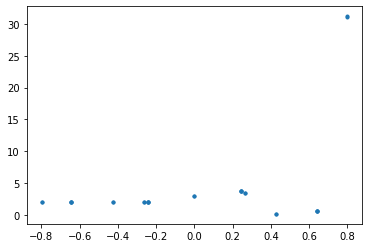

In [13]:
import numpy as np 
import scipy, h5py
import tables
import sys
from scipy.optimize import minimize
from scipy.optimize import rosen_der
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt
from scipy.linalg import norm
from numdifftools import Jacobian, Hessian
from sklearn.linear_model import Lasso
from sklearn.linear_model import TweedieRegressor
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

def ReadPMT():
    '''
    # Read PMT position
    # output: 2d PMT position 30*3 (x, y, z)
    '''
    f = open(r"../PMT_1t.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    return PMT_pos

def Legendre_coeff(PMT_pos, vertex, cut):
    '''
    # calulate the Legendre value of transformed X
    # input: PMT_pos: PMT No * 3
          vertex: 'v' 
          cut: cut off of Legendre polynomial
    # output: x: as 'X' at the beginnig    
    
    '''
    size = np.size(PMT_pos[:,0])
    # oh, it will use norm in future version
    if(np.sum(vertex**2) > 1e-6):
        cos_theta = np.sum(vertex*PMT_pos,axis=1)\
            /np.sqrt(np.sum(vertex**2)*np.sum(PMT_pos**2,axis=1))
    else:
        # make r=0 as a boundry, it should be improved
        cos_theta = np.ones(size)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_theta,c)
    return x

def readfile(filename):
    '''
    # Read single file
    # input: filename [.h5]
    # output: EventID, ChannelID, x, y, z
    '''
    h1 = tables.open_file(filename,'r')
    print(filename, flush=True)
    truthtable = h1.root.GroundTruth
    EventID = truthtable[:]['EventID']
    ChannelID = truthtable[:]['ChannelID']
    
    x = h1.root.TruthData[:]['x']
    y = h1.root.TruthData[:]['y']
    z = h1.root.TruthData[:]['z']
    h1.close()
    
    # The following part is to avoid trigger by dn(dark noise) since threshold is 1
    # These thiggers will be recorded as (0,0,0) by uproot
    # but in root, the truth and the trigger is not one to one
    # If the simulation vertex is (0,0,0), it is ambiguous, so we need cut off (0,0,0) or use data without dn
    # If the simulation set -dn 0, whether the program will get into the following part is not tested
    
    dn = np.where((x==0) & (y==0) & (z==0))
    dn_index = (x==0) & (y==0) & (z==0)
    pin = dn[0] + np.min(EventID)
    if(np.sum(x**2+y**2+z**2>0.1)>0):
        cnt = 0        
        for ID in np.arange(np.min(EventID), np.max(EventID)+1):
            if ID in pin:
                cnt = cnt+1
                #print('Trigger No:', EventID[EventID==ID])
                #print('Fired PMT', ChannelID[EventID==ID])
                
                ChannelID = ChannelID[~(EventID == ID)]
                EventID = EventID[~(EventID == ID)]
        x = x[~dn_index]
        y = y[~dn_index]
        z = z[~dn_index]
    return (EventID, ChannelID, x, y, z)
    
def readchain(radius, path, axis):

    for i in np.arange(0, 5):
        if(i == 0):
            # filename = path + '1t_' + radius + '.h5'
            # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030.h5
            filename = '%s1t_%s_%s.h5' % (path, radius, axis)
            EventID, ChannelID, x, y, z = readfile(filename)
        else:
            try:
                # filename = path + '1t_' + radius + '_n.h5'
                # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030_1.h5
                filename = '%s1t_%s_%s_%d.h5' % (path, radius, axis, i)
                EventID1, ChannelID1, x1, y1, z1 = readfile(filename)
                EventID = np.hstack((EventID, EventID1))
                ChannelID = np.hstack((ChannelID, ChannelID1))
                x = np.hstack((x, x1))
                y = np.hstack((y, y1))
                z = np.hstack((z, z1))
            except:
                pass

    return EventID, ChannelID, x, y, z
    
def main_Calib_hit(radius, path):
    print('begin reading file', flush=True)
    #filename = '/mnt/stage/douwei/Simulation/1t_root/1.5MeV_015/1t_' + radius + '.h5'
    
    EventIDx, ChannelIDx, xx, yx, zx = readchain('+' + radius, path, 'x')
    x1 = np.array((xx[0], yx[0], zx[0]))
    size = np.size(np.unique(EventIDx))

    EventID = EventIDx
    ChannelID = ChannelIDx

    total_pe = np.zeros(np.size(PMT_pos[:,0])*size)
    vertex = np.zeros((3,np.size(PMT_pos[:,0])*size))
    print('total event: %d' % np.size(np.unique(EventID)), flush=True)

    for k_index, k in enumerate(np.unique(EventID)):
        if not k_index % 1e4:
            print('preprocessing %d-th event' % k_index, flush=True)
        hit = ChannelID[EventID == k]
        tabulate = np.bincount(hit)
        event_pe = np.zeros(np.size(PMT_pos[:,0]))
        # tabulate begin with 0
        event_pe[0:np.size(tabulate)] = tabulate
        total_pe[(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = event_pe

    vs = np.reshape(total_pe[0:size*30],(-1,30), order='C')
    mean = np.mean(vs, axis=0)
    plt.plot(PMT_pos[:,0],mean,'.')
    
def main_Calib_photon(radius, path):
    print('begin reading file', flush=True)

    EventIDx, ChannelIDx, xx, yx, zx = readchain(sign + radius, path, axis)
    x1 = np.array((xx[0], yx[0], zx[0]))
    size = np.size(np.unique(EventIDx))

    EventID = EventIDx
    ChannelID = ChannelIDx

    total_pe = np.zeros(np.size(PMT_pos[:,0])*size)
    vertex = np.zeros((3,np.size(PMT_pos[:,0])*size))
    print('total event: %d' % np.size(np.unique(EventID)), flush=True)

    for k_index, k in enumerate(np.unique(EventID)):
        if not k_index % 1e4:
            print('preprocessing %d-th event' % k_index, flush=True)
        hit = ChannelID[EventID == k]
        tabulate = np.bincount(hit)
        event_pe = np.zeros(np.size(PMT_pos[:,0]))
        # tabulate begin with 0
        event_pe[0:np.size(tabulate)] = tabulate
        total_pe[(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = event_pe
    vs = np.reshape(total_pe[0:size*30],(-1,30), order='C')
    mean = np.mean(vs, axis=0)
    plt.plot(PMT_pos[:,0],mean,'.')
    
PMT_pos = ReadPMT()
main_Calib_hit('0.600', '/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/')
main_Calib_photon('0.600', '/mnt/stage/douwei/Simulation/1t_root/track/')

begin reading file
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.600_z.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.600_z_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.600_z_2.h5
total event: 19961
preprocessing 0-th event
preprocessing 10000-th event
(1927,) 0
(1864,) 1
(1974,) 2
(1899,) 3
(1960,) 4
(1968,) 5
(2098,) 6
(1898,) 7
(1967,) 8
(2012,) 9
(1940,) 10
(1965,) 11
(2037,) 12
(1993,) 13
(1999,) 14
(1994,) 15
(2025,) 16
(2011,) 17
(1909,) 18
(1960,) 19
(1969,) 20
(2045,) 21
(1948,) 22
(2009,) 23
(2029,) 24
(2022,) 25
(1979,) 26
(1866,) 27
(2006,) 28
(1918,) 29
(1985,) 30
(2037,) 31
(2060,) 32
(1962,) 33
(1973,) 34
(1990,) 35
(1856,) 36
(1988,) 37
(1823,) 38
(2039,) 39
(1956,) 40
(2083,) 41
(1945,) 42
(2054,) 43
(1954,) 44
(1984,) 45
(2037,) 46
(2002,) 47
(1837,) 48
(1959,) 49
(2074,) 50
(2041,) 51
(1947,) 52
(2069,) 53
(2029,) 54
(1948,) 55
(2009,) 56
(2013,) 57
(1983,) 58
(1962,) 59
(1903,) 60
(2042,) 61
(1947,) 62
(2014,) 63
(2034,) 64
(1946,) 65

No handles with labels found to put in legend.


(1964,) 100


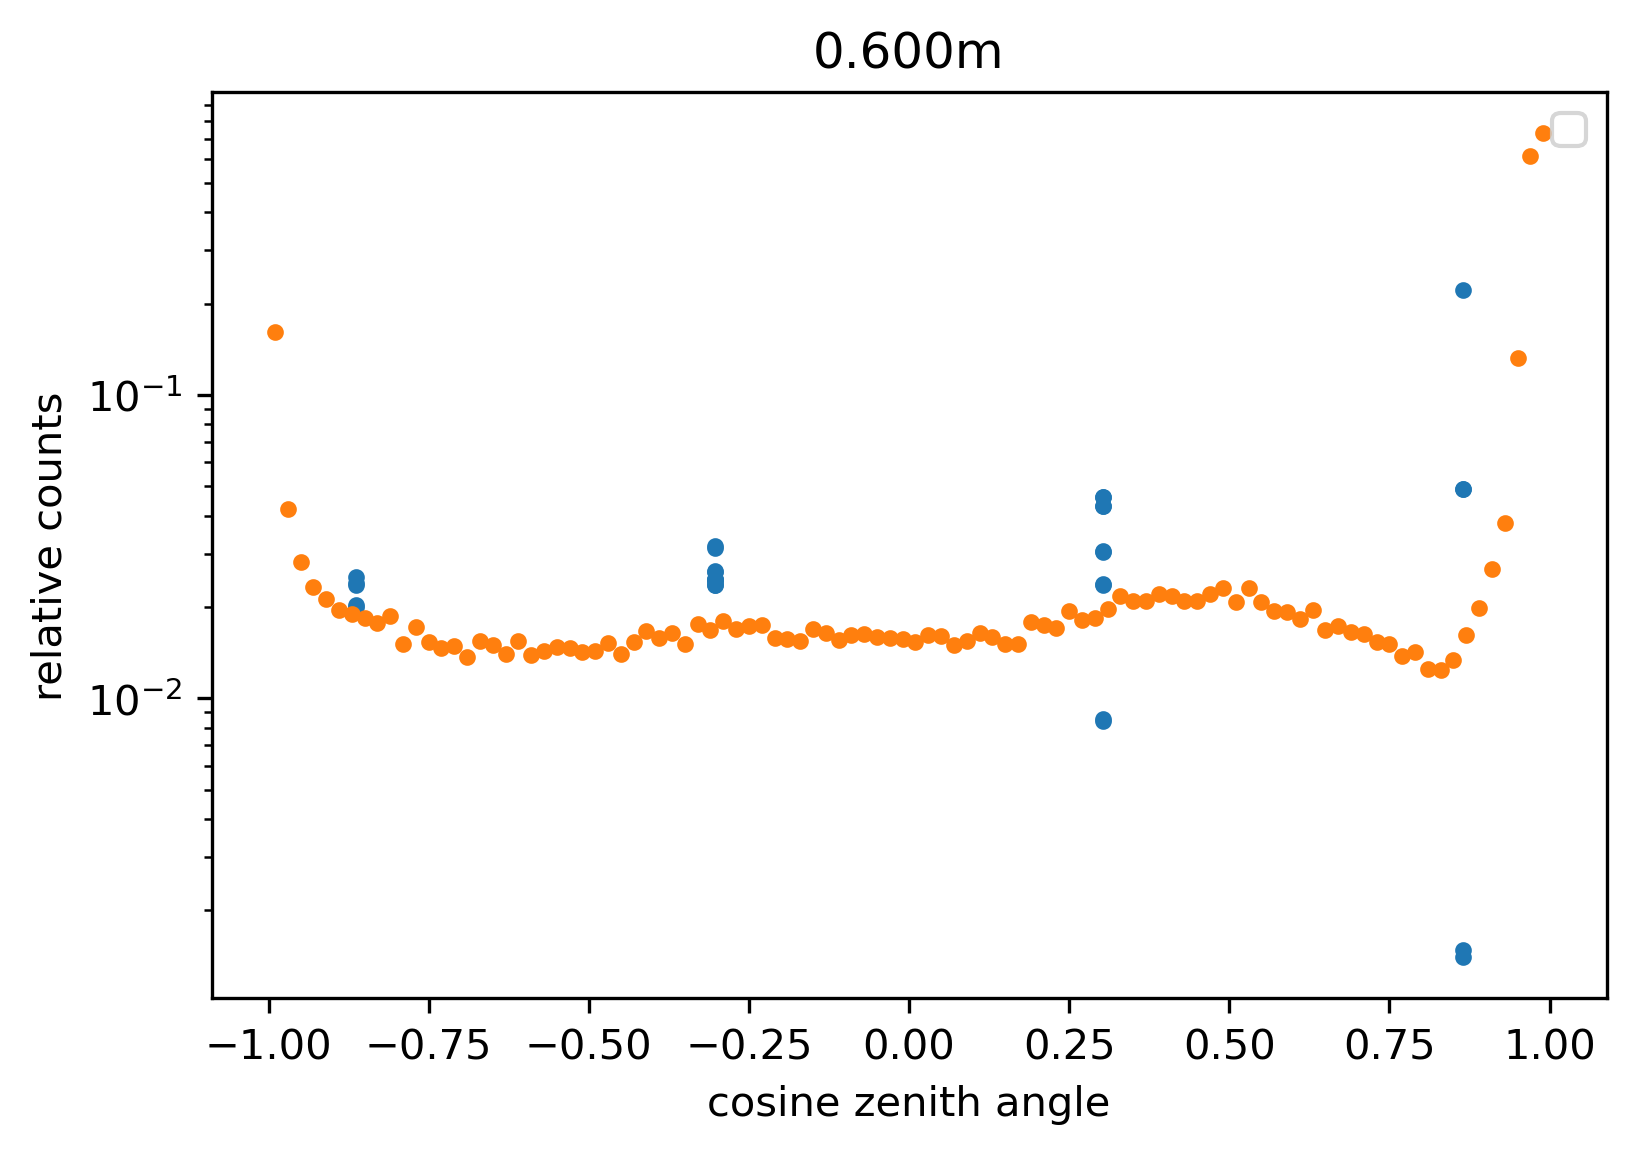

In [70]:
import numpy as np 
import scipy, h5py
import tables
import sys
import ROOT as root
from scipy.optimize import minimize
from scipy.optimize import rosen_der
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt
from scipy.linalg import norm
from numdifftools import Jacobian, Hessian
from sklearn.linear_model import Lasso
from sklearn.linear_model import TweedieRegressor
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

def ReadPMT():
    '''
    # Read PMT position
    # output: 2d PMT position 30*3 (x, y, z)
    '''
    f = open(r"../PMT_1t.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    return PMT_pos

def Legendre_coeff(PMT_pos, vertex, cut):
    '''
    # calulate the Legendre value of transformed X
    # input: PMT_pos: PMT No * 3
          vertex: 'v' 
          cut: cut off of Legendre polynomial
    # output: x: as 'X' at the beginnig    
    
    '''
    size = np.size(PMT_pos[:,0])
    # oh, it will use norm in future version
    if(np.sum(vertex**2) > 1e-6):
        cos_theta = np.sum(vertex*PMT_pos,axis=1)\
            /np.sqrt(np.sum(vertex**2)*np.sum(PMT_pos**2,axis=1))
    else:
        # make r=0 as a boundry, it should be improved
        cos_theta = np.ones(size)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_theta,c)
    return x

def readfile(filename):
    '''
    # Read single file
    # input: filename [.h5]
    # output: EventID, ChannelID, x, y, z
    '''
    h1 = tables.open_file(filename,'r')
    print(filename, flush=True)
    truthtable = h1.root.GroundTruth
    EventID = truthtable[:]['EventID']
    ChannelID = truthtable[:]['ChannelID']
    
    x = h1.root.TruthData[:]['x']
    y = h1.root.TruthData[:]['y']
    z = h1.root.TruthData[:]['z']
    h1.close()
    
    # The following part is to avoid trigger by dn(dark noise) since threshold is 1
    # These thiggers will be recorded as (0,0,0) by uproot
    # but in root, the truth and the trigger is not one to one
    # If the simulation vertex is (0,0,0), it is ambiguous, so we need cut off (0,0,0) or use data without dn
    # If the simulation set -dn 0, whether the program will get into the following part is not tested
    
    dn = np.where((x==0) & (y==0) & (z==0))
    dn_index = (x==0) & (y==0) & (z==0)
    pin = dn[0] + np.min(EventID)
    if(np.sum(x**2+y**2+z**2>0.1)>0):
        cnt = 0
        for ID in np.arange(np.min(EventID), np.max(EventID)+1):
            if ID in pin:
                cnt = cnt+1
                #print('Trigger No:', EventID[EventID==ID])
                #print('Fired PMT', ChannelID[EventID==ID])
                
                ChannelID = ChannelID[~(EventID == ID)]
                EventID = EventID[~(EventID == ID)]
        x = x[~dn_index]
        y = y[~dn_index]
        z = z[~dn_index]
    return (EventID, ChannelID, x, y, z)
    
def readchain(radius, path, axis):

    for i in np.arange(0, 5):
        if(i == 0):
            # filename = path + '1t_' + radius + '.h5'
            # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030.h5
            filename = '%s1t_%s_%s.h5' % (path, radius, axis)
            EventID, ChannelID, x, y, z = readfile(filename)
        else:
            try:
                # filename = path + '1t_' + radius + '_n.h5'
                # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030_1.h5
                filename = '%s1t_%s_%s_%d.h5' % (path, radius, axis, i)
                EventID1, ChannelID1, x1, y1, z1 = readfile(filename)
                EventID = np.hstack((EventID, EventID1))
                ChannelID = np.hstack((ChannelID, ChannelID1))
                x = np.hstack((x, x1))
                y = np.hstack((y, y1))
                z = np.hstack((z, z1))
            except:
                pass

    return EventID, ChannelID, x, y, z
    
def main_Calib_hit(radius, path):
    print('begin reading file', flush=True)
    #filename = '/mnt/stage/douwei/Simulation/1t_root/1.5MeV_015/1t_' + radius + '.h5'
    
    EventIDx, ChannelIDx, xx, yx, zx = readchain('+' + radius, path, 'z')
    x1 = np.array((xx[0], yx[0], zx[0]))
    size = np.size(np.unique(EventIDx))

    EventID = EventIDx
    ChannelID = ChannelIDx

    total_pe = np.zeros(np.size(PMT_pos[:,0])*size)
    vertex = np.zeros((3,np.size(PMT_pos[:,0])*size))
    print('total event: %d' % np.size(np.unique(EventID)), flush=True)

    for k_index, k in enumerate(np.unique(EventID)):
        if not k_index % 1e4:
            print('preprocessing %d-th event' % k_index, flush=True)
        hit = ChannelID[EventID == k]
        tabulate = np.bincount(hit)
        event_pe = np.zeros(np.size(PMT_pos[:,0]))
        # tabulate begin with 0
        event_pe[0:np.size(tabulate)] = tabulate
        total_pe[(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = event_pe

    vs = np.reshape(total_pe[0:size*30],(-1,30), order='C')
    mean = np.mean(vs, axis=0)

    return PMT_pos[:,2]/0.81, mean
    
def main_Calib_photon(radius, path):
    ths = 100
    for i in np.arange(0,1):
        if(i==0):
            f = root.TFile(path + '/1t_%+.3f_z.root' % eval(radius))
        else:
            f = root.TFile(path + '/1t_%+.3f_z_%d.root' % (eval(radius), i))
        myTree = f.Get("SimTriggerInfo")
        N = myTree.GetEntries()
        bins = np.int(100)
        pe = np.zeros((N, bins))
        total_pe = np.zeros(bins*N)
        PMT_pos = np.zeros((bins*N, 3))
        cnt = 0
        for entry in myTree:
            # Now you have acess to the leaves/branches of each entry in the tree, e.g.
            for a in entry:
                if(cnt>ths):
                    break
                events = a.truthList
                for b in events:
                    if(cnt>ths):
                        break
                    x_tmp = []
                    y_tmp = []
                    z_tmp = []
                    x = []
                    y = []
                    z = []
                    for c in b.trackList:
                        if(cnt>ths):
                            break
                        track = 1
                        for d in c.StepPoints:

                            if(track == c.nTrackId):
                                x_tmp.append(d.fX)
                                y_tmp.append(d.fY)
                                z_tmp.append(d.fZ)
                                track = c.nTrackId
                            else:
                                track = c.nTrackId
                                r = np.sqrt(np.array(x_tmp)**2 + np.array(y_tmp)**2 + np.array(z_tmp)**2)
                                if(np.sum(r>651)>1):
                                    index = np.where((r<651) & (r>644))
                                    if(len(index[0])>0):
                                        x.append(x_tmp[index[0][-1]])
                                        y.append(y_tmp[index[0][-1]])
                                        z.append(z_tmp[index[0][-1]])
                                        #print(r[index[0][-1]],z_tmp[index[0][-1]], c.nTrackId)
                                    else:
                                        pass
                                else:
                                    pass

                    x = np.array(x)
                    y = np.array(y)
                    z = np.array(z)
                    print(x.shape,c.nSegmentId)
                    cnt = cnt + 1
                    #print(total_pe.shape, cnt*bins)
                    H, xedges = np.histogram(np.cos(np.arccos(z/np.sqrt(x**2+y**2+z**2))), bins=bins, range=(-1,1))
                    #plt.plot(xedges[1:],H)
                    #plt.hist(z)
                    #plt.hist(np.arccos(z/np.sqrt(x**2+y**2+z**2)))
                    #plt.savefig('view1.png')
                    #exit()
                    pe[cnt-1] = H
                    total_pe[(cnt-1)*bins:(cnt*bins)] = H
                    x_tmp = []
                    y_tmp = []
                    z_tmp = []
                    x_tmp.append(d.fX)
                    y_tmp.append(d.fY)
                    z_tmp.append(d.fZ)
            break
        break
    vertex = (xedges[1:]+xedges[:-1])/2
    return vertex, total_pe


PMT_pos = ReadPMT()
radius = '0.600'
vertex0,total_pe0 = main_Calib_hit(radius, '/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/')
vertex1,total_pe1 = main_Calib_photon(radius, '/mnt/stage/douwei/Simulation/1t_root/track_water/')

plt.figure(dpi=300)
vs0 = np.reshape(total_pe0,(-1,30), order='C')
mean0 = np.mean(vs0, axis=0)
plt.plot(vertex0,mean0/np.sum(mean0),'.')

vs1 = np.reshape(total_pe1,(-1,100), order='C')
mean1 = np.mean(vs1, axis=0)
plt.plot(vertex1,mean1/np.sum(mean1)*100/30,'.')
plt.xlabel('cosine zenith angle')
plt.ylabel('relative counts')
plt.semilogy()
plt.title(f'{radius}m')
plt.legend()

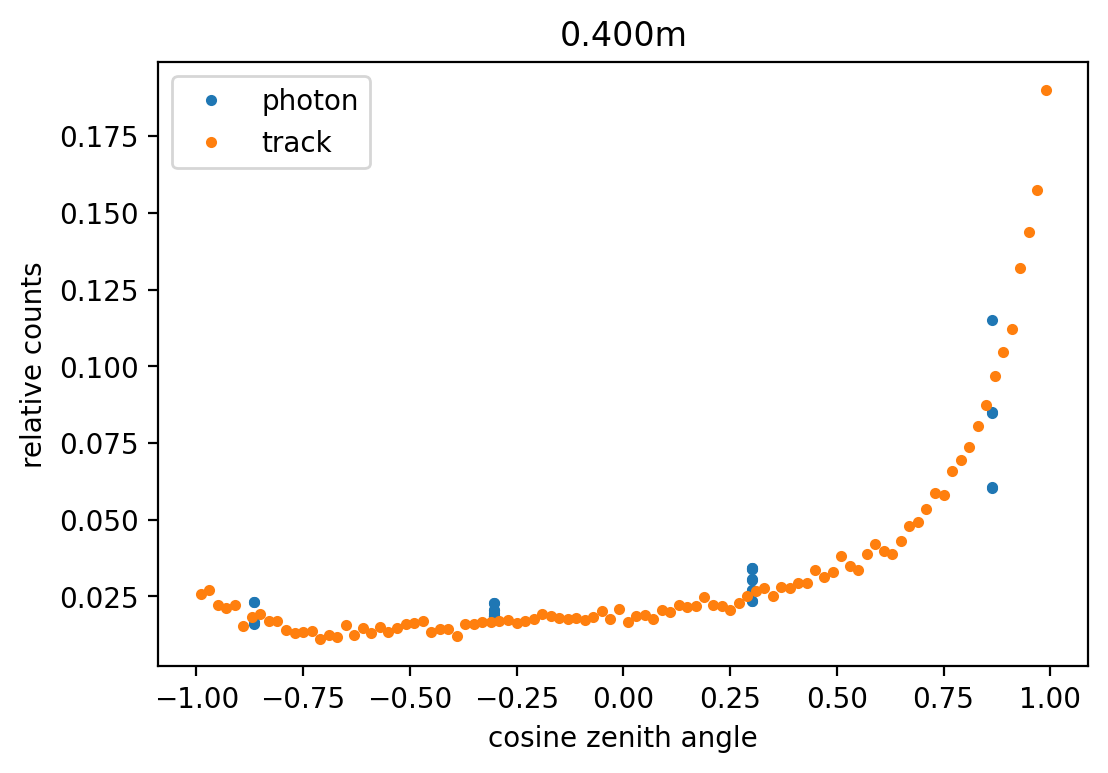

In [46]:
plt.figure(dpi=200)
vs0 = np.reshape(total_pe0,(-1,30), order='C')
mean0 = np.mean(vs0, axis=0)
plt.plot(vertex0,mean0/np.sum(mean0),'.',label='photon')

vs1 = np.reshape(total_pe1,(-1,100), order='C')
mean1 = np.mean(vs1, axis=0)
plt.plot(vertex1,mean1/np.sum(mean1)*100/30,'.', label='track')

plt.xlabel('cosine zenith angle')
plt.ylabel('relative counts')
plt.title(f'{radius}m')
plt.legend()

begin reading file
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.550_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.550_x_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.550_x_2.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.550_x_3.h5
total event: 19969
preprocessing 0-th event
preprocessing 10000-th event
(2007,) 0
(2005,) 1
(1943,) 2
(2063,) 3
(1969,) 4
(1973,) 5
(1909,) 6
(1937,) 7
(2027,) 8
(1924,) 9
(1940,) 10
(1999,) 11
(2040,) 12
(2035,) 13
(1979,) 14
(1932,) 15
(1974,) 16
(1988,) 17
(2003,) 18
(2001,) 19
(1979,) 20
(2002,) 21
(1868,) 22
(2005,) 23
(2052,) 24
(1838,) 25
(2144,) 26
(2028,) 27
(1961,) 28
(1979,) 29


No handles with labels found to put in legend.


(2020,) 30


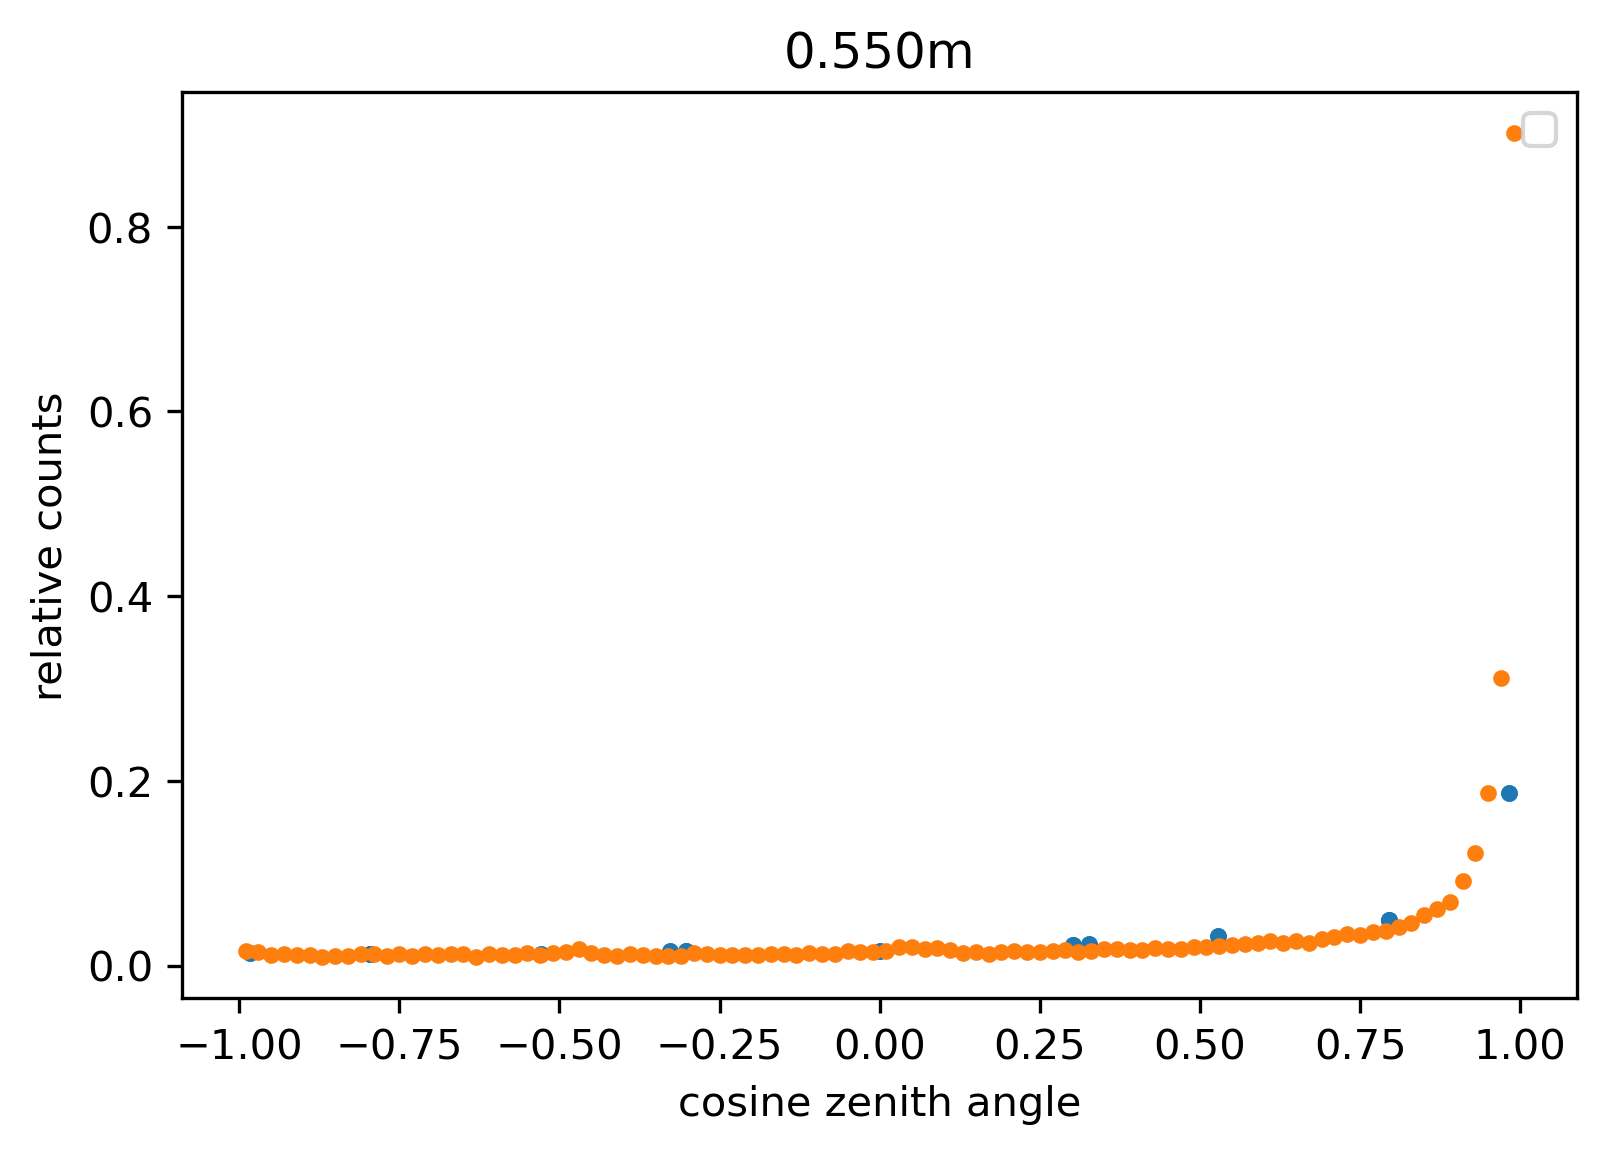

In [49]:
import numpy as np 
import scipy, h5py
import tables
import sys
import ROOT as root
from scipy.optimize import minimize
from scipy.optimize import rosen_der
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt
from scipy.linalg import norm
from numdifftools import Jacobian, Hessian
from sklearn.linear_model import Lasso
from sklearn.linear_model import TweedieRegressor
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

def ReadPMT():
    '''
    # Read PMT position
    # output: 2d PMT position 30*3 (x, y, z)
    '''
    f = open(r"../PMT_1t.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    return PMT_pos

def Legendre_coeff(PMT_pos, vertex, cut):
    '''
    # calulate the Legendre value of transformed X
    # input: PMT_pos: PMT No * 3
          vertex: 'v' 
          cut: cut off of Legendre polynomial
    # output: x: as 'X' at the beginnig    
    
    '''
    size = np.size(PMT_pos[:,0])
    # oh, it will use norm in future version
    if(np.sum(vertex**2) > 1e-6):
        cos_theta = np.sum(vertex*PMT_pos,axis=1)\
            /np.sqrt(np.sum(vertex**2)*np.sum(PMT_pos**2,axis=1))
    else:
        # make r=0 as a boundry, it should be improved
        cos_theta = np.ones(size)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_theta,c)
    return x

def readfile(filename):
    '''
    # Read single file
    # input: filename [.h5]
    # output: EventID, ChannelID, x, y, z
    '''
    h1 = tables.open_file(filename,'r')
    print(filename, flush=True)
    truthtable = h1.root.GroundTruth
    EventID = truthtable[:]['EventID']
    ChannelID = truthtable[:]['ChannelID']
    
    x = h1.root.TruthData[:]['x']
    y = h1.root.TruthData[:]['y']
    z = h1.root.TruthData[:]['z']
    h1.close()
    
    # The following part is to avoid trigger by dn(dark noise) since threshold is 1
    # These thiggers will be recorded as (0,0,0) by uproot
    # but in root, the truth and the trigger is not one to one
    # If the simulation vertex is (0,0,0), it is ambiguous, so we need cut off (0,0,0) or use data without dn
    # If the simulation set -dn 0, whether the program will get into the following part is not tested
    
    dn = np.where((x==0) & (y==0) & (z==0))
    dn_index = (x==0) & (y==0) & (z==0)
    pin = dn[0] + np.min(EventID)
    if(np.sum(x**2+y**2+z**2>0.1)>0):
        cnt = 0
        for ID in np.arange(np.min(EventID), np.max(EventID)+1):
            if ID in pin:
                cnt = cnt+1
                #print('Trigger No:', EventID[EventID==ID])
                #print('Fired PMT', ChannelID[EventID==ID])
                
                ChannelID = ChannelID[~(EventID == ID)]
                EventID = EventID[~(EventID == ID)]
        x = x[~dn_index]
        y = y[~dn_index]
        z = z[~dn_index]
    return (EventID, ChannelID, x, y, z)
    
def readchain(radius, path, axis):

    for i in np.arange(0, 5):
        if(i == 0):
            # filename = path + '1t_' + radius + '.h5'
            # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030.h5
            filename = '%s1t_%s_%s.h5' % (path, radius, axis)
            EventID, ChannelID, x, y, z = readfile(filename)
        else:
            try:
                # filename = path + '1t_' + radius + '_n.h5'
                # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030_1.h5
                filename = '%s1t_%s_%s_%d.h5' % (path, radius, axis, i)
                EventID1, ChannelID1, x1, y1, z1 = readfile(filename)
                EventID = np.hstack((EventID, EventID1))
                ChannelID = np.hstack((ChannelID, ChannelID1))
                x = np.hstack((x, x1))
                y = np.hstack((y, y1))
                z = np.hstack((z, z1))
            except:
                pass

    return EventID, ChannelID, x, y, z
    
def main_Calib_hit(radius, path):
    print('begin reading file', flush=True)
    #filename = '/mnt/stage/douwei/Simulation/1t_root/1.5MeV_015/1t_' + radius + '.h5'
    
    EventIDx, ChannelIDx, xx, yx, zx = readchain('+' + radius, path, 'x')
    x1 = np.array((xx[0], yx[0], zx[0]))
    size = np.size(np.unique(EventIDx))

    EventID = EventIDx
    ChannelID = ChannelIDx

    total_pe = np.zeros(np.size(PMT_pos[:,0])*size)
    vertex = np.zeros((3,np.size(PMT_pos[:,0])*size))
    print('total event: %d' % np.size(np.unique(EventID)), flush=True)

    for k_index, k in enumerate(np.unique(EventID)):
        if not k_index % 1e4:
            print('preprocessing %d-th event' % k_index, flush=True)
        hit = ChannelID[EventID == k]
        tabulate = np.bincount(hit)
        event_pe = np.zeros(np.size(PMT_pos[:,0]))
        # tabulate begin with 0
        event_pe[0:np.size(tabulate)] = tabulate
        total_pe[(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = event_pe

    vs = np.reshape(total_pe[0:size*30],(-1,30), order='C')
    mean = np.mean(vs, axis=0)

    return PMT_pos[:,0]/0.81, mean
    
def main_Calib_photon(radius, path):
    ths = 30
    for i in np.arange(0,1):
        if(i==0):
            f = root.TFile(path + '/1t_%+.3f_x.root' % eval(radius))
        else:
            f = root.TFile(path + '/1t_%+.3f_x_%d.root' % (eval(radius), i))
        myTree = f.Get("SimTriggerInfo")
        N = myTree.GetEntries()
        bins = np.int(100)
        pe = np.zeros((N, bins))
        total_pe = np.zeros(bins*N)
        PMT_pos = np.zeros((bins*N, 3))
        cnt = 0
        for entry in myTree:
            # Now you have acess to the leaves/branches of each entry in the tree, e.g.
            for a in entry:
                if(cnt>ths):
                    break
                events = a.truthList
                for b in events:
                    if(cnt>ths):
                        break
                    x_tmp = []
                    y_tmp = []
                    z_tmp = []
                    x = []
                    y = []
                    z = []
                    for c in b.trackList:
                        if(cnt>ths):
                            break
                        track = 1
                        for d in c.StepPoints:

                            if(track == c.nTrackId):
                                x_tmp.append(d.fX)
                                y_tmp.append(d.fY)
                                z_tmp.append(d.fZ)
                                track = c.nTrackId
                            else:
                                track = c.nTrackId
                                r = np.sqrt(np.array(x_tmp)**2 + np.array(y_tmp)**2 + np.array(z_tmp)**2)
                                if(np.sum(r>651)>1):
                                    index = np.where((r<651) & (r>644))
                                    if(len(index[0])>0):
                                        x.append(x_tmp[index[0][-1]])
                                        y.append(y_tmp[index[0][-1]])
                                        z.append(z_tmp[index[0][-1]])
                                        #print(r[index[0][-1]],z_tmp[index[0][-1]], c.nTrackId)
                                    else:
                                        pass
                                else:
                                    pass

                    x = np.array(x)
                    y = np.array(y)
                    z = np.array(z)
                    print(x.shape,c.nSegmentId)
                    cnt = cnt + 1
                    #print(total_pe.shape, cnt*bins)
                    H, xedges = np.histogram(np.cos(np.arccos(x/np.sqrt(x**2+y**2+z**2))), bins=bins, range=(-1,1))
                    #plt.plot(xedges[1:],H)
                    #plt.hist(z)
                    #plt.hist(np.arccos(z/np.sqrt(x**2+y**2+z**2)))
                    #plt.savefig('view1.png')
                    #exit()
                    pe[cnt-1] = H
                    total_pe[(cnt-1)*bins:(cnt*bins)] = H
                    x_tmp = []
                    y_tmp = []
                    z_tmp = []
                    x_tmp.append(d.fX)
                    y_tmp.append(d.fY)
                    z_tmp.append(d.fZ)
            break
        break
    vertex = (xedges[1:]+xedges[:-1])/2
    return vertex, total_pe


PMT_pos = ReadPMT()
radius = '0.550'
vertex0,total_pe0 = main_Calib_hit(radius, '/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/')
vertex1,total_pe1 = main_Calib_photon(radius, '/mnt/stage/douwei/Simulation/1t_root/track_water/')

plt.figure(dpi=300)
vs0 = np.reshape(total_pe0,(-1,30), order='C')
mean0 = np.mean(vs0, axis=0)
plt.plot(vertex0,mean0/np.sum(mean0),'.')

vs1 = np.reshape(total_pe1,(-1,100), order='C')
mean1 = np.mean(vs1, axis=0)
plt.plot(vertex1,mean1/np.sum(mean1)*100/30,'.')
plt.xlabel('cosine zenith angle')
plt.ylabel('relative counts')
plt.title(f'{radius}m')
plt.legend()

begin reading file
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_notr_10000/1t_+0.620_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_notr_10000/1t_+0.620_x_1.h5
total event: 9993
preprocessing 0-th event
begin reading file
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.620_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.620_x_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/1t_+0.620_x_2.h5
total event: 19972
preprocessing 0-th event
preprocessing 10000-th event
begin reading file
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_noreflection/1t_+0.620_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_noreflection/1t_+0.620_x_1.h5
total event: 9991
preprocessing 0-th event


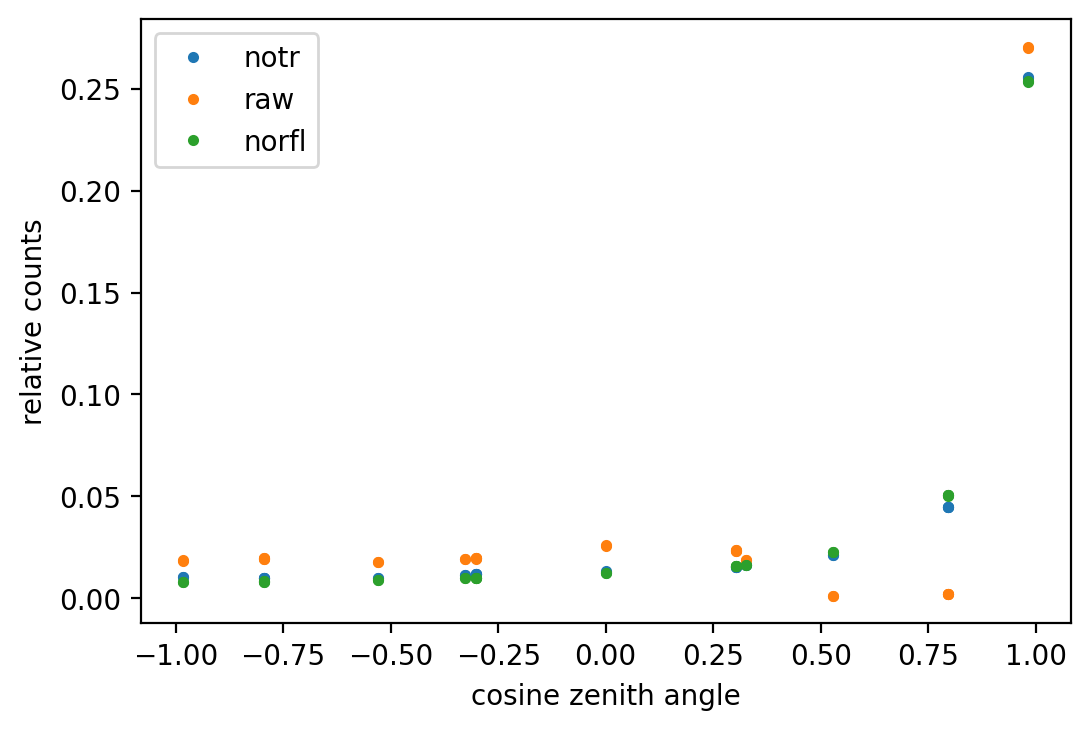

In [77]:
import numpy as np 
import scipy, h5py
import tables
import sys
import ROOT as root
from scipy.optimize import minimize
from scipy.optimize import rosen_der
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt
from scipy.linalg import norm
from numdifftools import Jacobian, Hessian
from sklearn.linear_model import Lasso
from sklearn.linear_model import TweedieRegressor
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

def ReadPMT():
    '''
    # Read PMT position
    # output: 2d PMT position 30*3 (x, y, z)
    '''
    f = open(r"../PMT_1t.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    return PMT_pos

def Legendre_coeff(PMT_pos, vertex, cut):
    '''
    # calulate the Legendre value of transformed X
    # input: PMT_pos: PMT No * 3
          vertex: 'v' 
          cut: cut off of Legendre polynomial
    # output: x: as 'X' at the beginnig    
    
    '''
    size = np.size(PMT_pos[:,0])
    # oh, it will use norm in future version
    if(np.sum(vertex**2) > 1e-6):
        cos_theta = np.sum(vertex*PMT_pos,axis=1)\
            /np.sqrt(np.sum(vertex**2)*np.sum(PMT_pos**2,axis=1))
    else:
        # make r=0 as a boundry, it should be improved
        cos_theta = np.ones(size)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_theta,c)
    return x

def readfile(filename):
    '''
    # Read single file
    # input: filename [.h5]
    # output: EventID, ChannelID, x, y, z
    '''
    h1 = tables.open_file(filename,'r')
    print(filename, flush=True)
    truthtable = h1.root.GroundTruth
    EventID = truthtable[:]['EventID']
    ChannelID = truthtable[:]['ChannelID']
    
    x = h1.root.TruthData[:]['x']
    y = h1.root.TruthData[:]['y']
    z = h1.root.TruthData[:]['z']
    h1.close()
    
    # The following part is to avoid trigger by dn(dark noise) since threshold is 1
    # These thiggers will be recorded as (0,0,0) by uproot
    # but in root, the truth and the trigger is not one to one
    # If the simulation vertex is (0,0,0), it is ambiguous, so we need cut off (0,0,0) or use data without dn
    # If the simulation set -dn 0, whether the program will get into the following part is not tested
    
    dn = np.where((x==0) & (y==0) & (z==0))
    dn_index = (x==0) & (y==0) & (z==0)
    pin = dn[0] + np.min(EventID)
    if(np.sum(x**2+y**2+z**2>0.1)>0):
        cnt = 0
        for ID in np.arange(np.min(EventID), np.max(EventID)+1):
            if ID in pin:
                cnt = cnt+1
                #print('Trigger No:', EventID[EventID==ID])
                #print('Fired PMT', ChannelID[EventID==ID])
                
                ChannelID = ChannelID[~(EventID == ID)]
                EventID = EventID[~(EventID == ID)]
        x = x[~dn_index]
        y = y[~dn_index]
        z = z[~dn_index]
    return (EventID, ChannelID, x, y, z)
    
def readchain(radius, path, axis):

    for i in np.arange(0, 5):
        if(i == 0):
            # filename = path + '1t_' + radius + '.h5'
            # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030.h5
            filename = '%s1t_%s_%s.h5' % (path, radius, axis)
            EventID, ChannelID, x, y, z = readfile(filename)
        else:
            try:
                # filename = path + '1t_' + radius + '_n.h5'
                # eg: /mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.030_1.h5
                filename = '%s1t_%s_%s_%d.h5' % (path, radius, axis, i)
                EventID1, ChannelID1, x1, y1, z1 = readfile(filename)
                EventID = np.hstack((EventID, EventID1))
                ChannelID = np.hstack((ChannelID, ChannelID1))
                x = np.hstack((x, x1))
                y = np.hstack((y, y1))
                z = np.hstack((z, z1))
            except:
                pass

    return EventID, ChannelID, x, y, z
    
def main_Calib_hit(radius, path):
    print('begin reading file', flush=True)
    #filename = '/mnt/stage/douwei/Simulation/1t_root/1.5MeV_015/1t_' + radius + '.h5'
    
    EventIDx, ChannelIDx, xx, yx, zx = readchain('+' + radius, path, 'x')
    x1 = np.array((xx[0], yx[0], zx[0]))
    size = np.size(np.unique(EventIDx))

    EventID = EventIDx
    ChannelID = ChannelIDx

    total_pe = np.zeros(np.size(PMT_pos[:,0])*size)
    vertex = np.zeros((3,np.size(PMT_pos[:,0])*size))
    print('total event: %d' % np.size(np.unique(EventID)), flush=True)

    for k_index, k in enumerate(np.unique(EventID)):
        if not k_index % 1e4:
            print('preprocessing %d-th event' % k_index, flush=True)
        hit = ChannelID[EventID == k]
        tabulate = np.bincount(hit)
        event_pe = np.zeros(np.size(PMT_pos[:,0]))
        # tabulate begin with 0
        event_pe[0:np.size(tabulate)] = tabulate
        total_pe[(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = event_pe

    vs = np.reshape(total_pe[0:size*30],(-1,30), order='C')
    mean = np.mean(vs, axis=0)

    return PMT_pos[:,0]/0.81, mean
    
def main_Calib_photon(radius, path):
    ths = 30
    for i in np.arange(0,1):
        if(i==0):
            f = root.TFile(path + '/1t_%+.3f_x.root' % eval(radius))
        else:
            f = root.TFile(path + '/1t_%+.3f_x_%d.root' % (eval(radius), i))
        myTree = f.Get("SimTriggerInfo")
        N = myTree.GetEntries()
        bins = np.int(100)
        pe = np.zeros((N, bins))
        total_pe = np.zeros(bins*N)
        PMT_pos = np.zeros((bins*N, 3))
        cnt = 0
        for entry in myTree:
            # Now you have acess to the leaves/branches of each entry in the tree, e.g.
            for a in entry:
                if(cnt>ths):
                    break
                events = a.truthList
                for b in events:
                    if(cnt>ths):
                        break
                    x_tmp = []
                    y_tmp = []
                    z_tmp = []
                    x = []
                    y = []
                    z = []
                    for c in b.trackList:
                        if(cnt>ths):
                            break
                        track = 1
                        for d in c.StepPoints:

                            if(track == c.nTrackId):
                                x_tmp.append(d.fX)
                                y_tmp.append(d.fY)
                                z_tmp.append(d.fZ)
                                track = c.nTrackId
                            else:
                                track = c.nTrackId
                                r = np.sqrt(np.array(x_tmp)**2 + np.array(y_tmp)**2 + np.array(z_tmp)**2)
                                if(np.sum(r>651)>1):
                                    index = np.where((r<651) & (r>644))
                                    if(len(index[0])>0):
                                        x.append(x_tmp[index[0][-1]])
                                        y.append(y_tmp[index[0][-1]])
                                        z.append(z_tmp[index[0][-1]])
                                        #print(r[index[0][-1]],z_tmp[index[0][-1]], c.nTrackId)
                                    else:
                                        pass
                                else:
                                    pass

                    x = np.array(x)
                    y = np.array(y)
                    z = np.array(z)
                    print(x.shape,c.nSegmentId)
                    cnt = cnt + 1
                    #print(total_pe.shape, cnt*bins)
                    H, xedges = np.histogram(np.cos(np.arccos(x/np.sqrt(x**2+y**2+z**2))), bins=bins, range=(-1,1))
                    #plt.plot(xedges[1:],H)
                    #plt.hist(z)
                    #plt.hist(np.arccos(z/np.sqrt(x**2+y**2+z**2)))
                    #plt.savefig('view1.png')
                    #exit()
                    pe[cnt-1] = H
                    total_pe[(cnt-1)*bins:(cnt*bins)] = H
                    x_tmp = []
                    y_tmp = []
                    z_tmp = []
                    x_tmp.append(d.fX)
                    y_tmp.append(d.fY)
                    z_tmp.append(d.fZ)
            break
        break
    vertex = (xedges[1:]+xedges[:-1])/2
    return vertex, total_pe


PMT_pos = ReadPMT()
radius = '0.620'
vertex0,total_pe0 = main_Calib_hit(radius, '/mnt/stage/douwei/Simulation/1t_root/2.0MeV_notr_10000/')
vertex1,total_pe1 = main_Calib_hit(radius, '/mnt/stage/douwei/Simulation/1t_root/2.0MeV_dns/')
vertex2,total_pe2 = main_Calib_hit(radius, '/mnt/stage/douwei/Simulation/1t_root/2.0MeV_noreflection/')


plt.figure(dpi=200)
'''
index = np.argsort(vs0)

vs0 = np.reshape(total_pe0,(-1,30), order='C')
mean0 = np.mean(vs0, axis=0)
plt.plot(vertex0[index[0]],'.',mean0[index[0]]/np.sum(mean0),label='notr')
vs1 = np.reshape(total_pe1,(-1,30), order='C')
mean1 = np.mean(vs1, axis=0)
plt.plot(vertex1[index[0]],'.',mean1[index[0]]/np.sum(mean1),label='raw')
vs2 = np.reshape(total_pe2,(-1,30), order='C')
mean2 = np.mean(vs2, axis=0)
plt.plot(vertex2[index[0]],'.',mean2[index[0]]/np.sum(mean2),label='norfl')
'''

vs0 = np.reshape(total_pe0,(-1,30), order='C')
mean0 = np.mean(vs0, axis=0)
plt.plot(vertex0,mean0/np.sum(mean0),'.',label='notr')
vs1 = np.reshape(total_pe1,(-1,30), order='C')
mean1 = np.mean(vs1, axis=0)
plt.plot(vertex1,mean1/np.sum(mean1),'.',label='raw')
vs2 = np.reshape(total_pe2,(-1,30), order='C')
mean2 = np.mean(vs2, axis=0)
plt.plot(vertex2,mean2/np.sum(mean2),'.',label='norfl')

plt.xlabel('cosine zenith angle')
plt.ylabel('relative counts')
plt.legend()

In [76]:
mean2

array([ 3.783,  2.747,  1.662,  1.675,  8.478,  1.311,  8.528,  1.679,
        2.027,  42.570,  1.371,  2.651,  2.675,  1.353,  3.763,  2.743,
        1.516,  8.487,  1.286,  8.458,  1.675,  1.677,  2.040,  1.531,
        1.680,  2.657,  1.379,  42.626,  1.362,  2.663])

Text(0.5, 1.0, '0.620m')

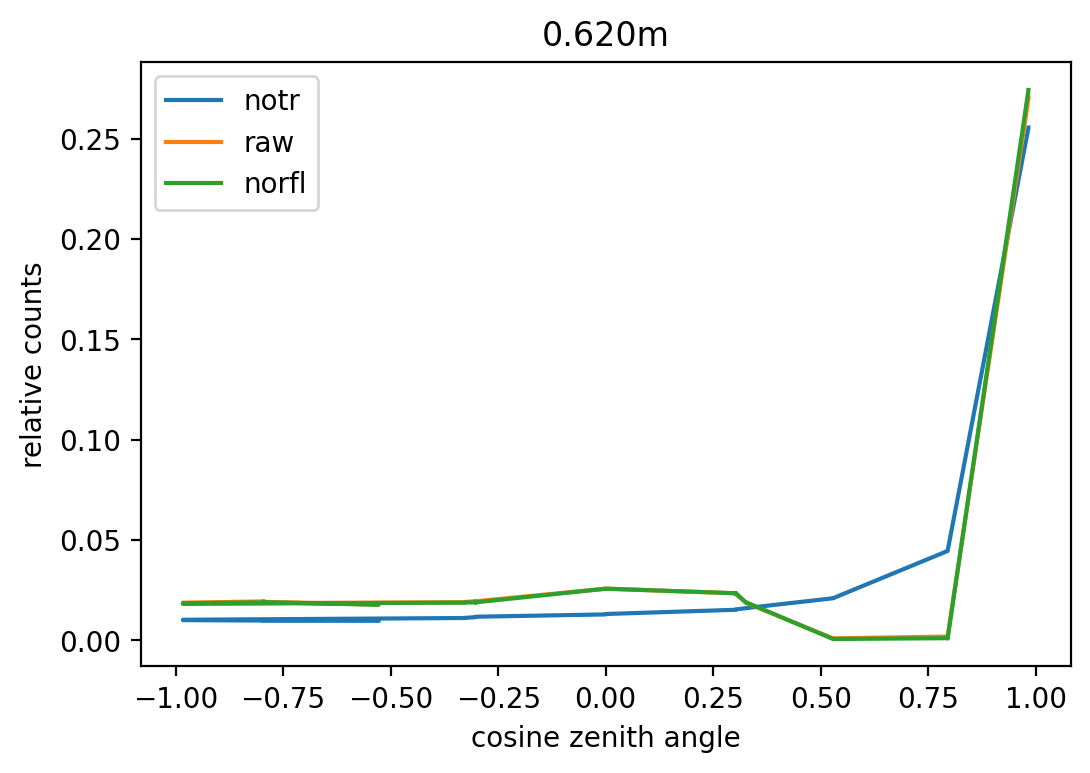

In [65]:
plt.figure(dpi=200)
index = np.argsort(vs0)

vs0 = np.reshape(total_pe0,(-1,30), order='C')
mean0 = np.mean(vs0, axis=0)
plt.plot(vertex0[index[0]],mean0[index[0]]/np.sum(mean0),label='notr')
vs1 = np.reshape(total_pe1,(-1,30), order='C')
mean1 = np.mean(vs1, axis=0)
plt.plot(vertex1[index[0]],mean1[index[0]]/np.sum(mean1),label='raw')
vs2 = np.reshape(total_pe2,(-1,30), order='C')
mean2 = np.mean(vs2, axis=0)
plt.plot(vertex2[index[0]],mean2[index[0]]/np.sum(mean2),label='norfl')

plt.xlabel('cosine zenith angle')
plt.ylabel('relative counts')
plt.legend()
plt.title(f'{radius}m')


ValueError: cannot reshape array of size 30 into shape (100)

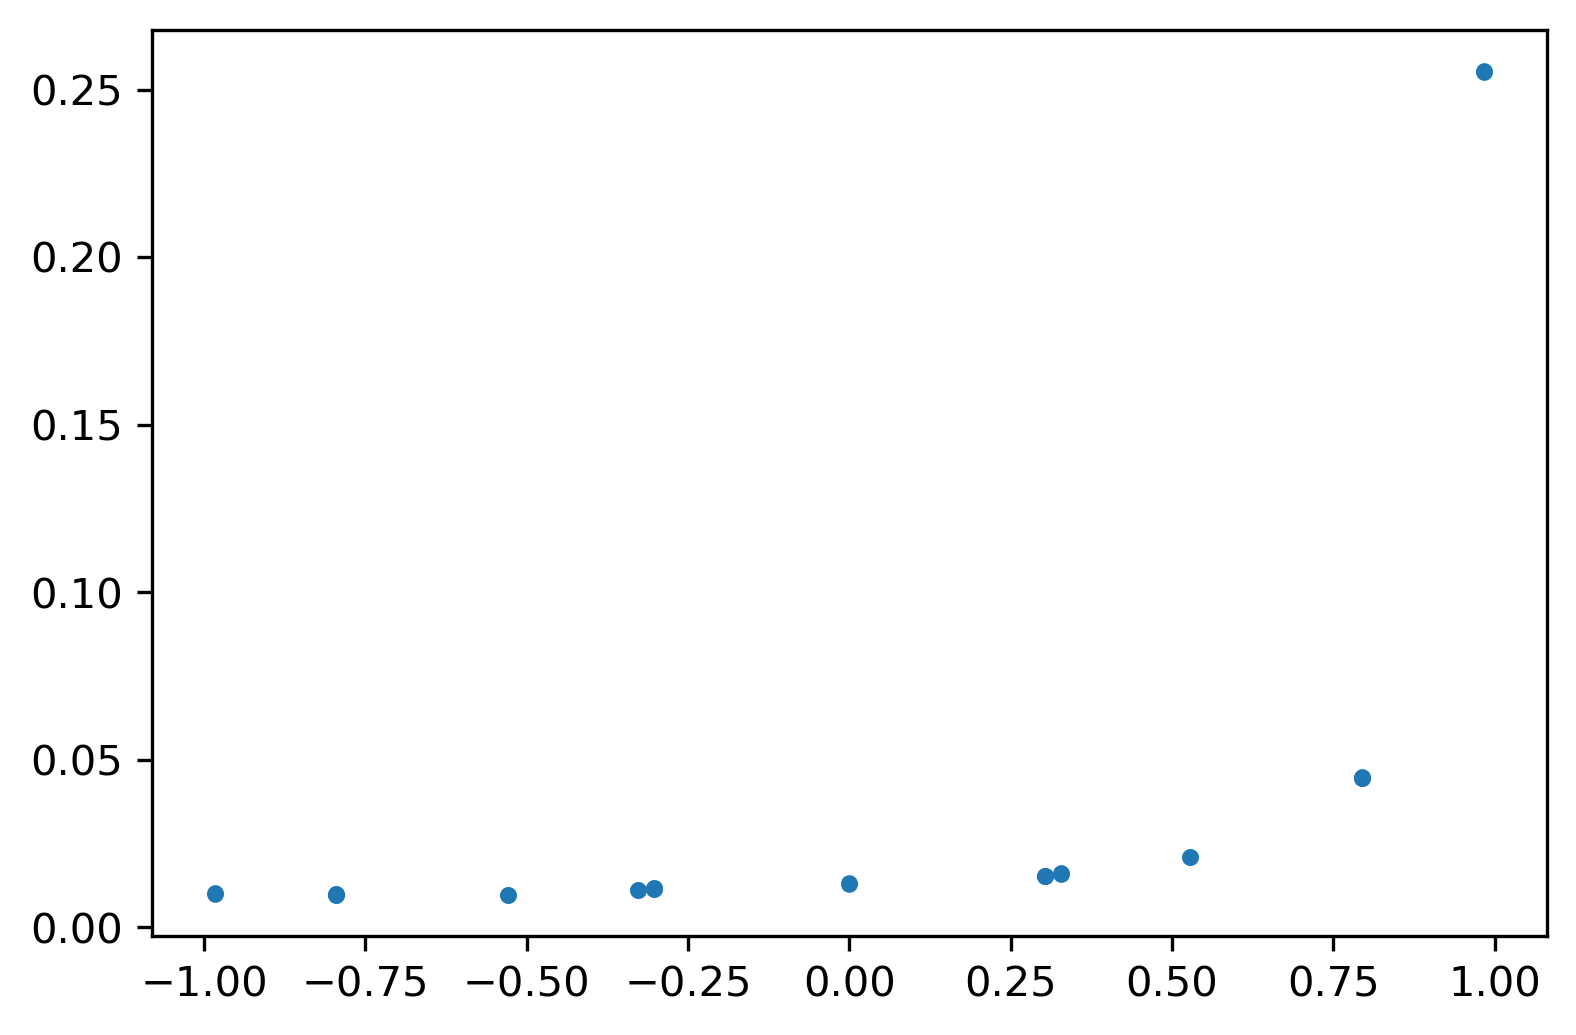

In [67]:
plt.figure(dpi=300)
vs0 = np.reshape(total_pe0,(-1,30), order='C')
mean0 = np.mean(vs0, axis=0)
plt.plot(vertex0,mean0/np.sum(mean0),'.')

vs1 = np.reshape(total_pe1,(-1,100), order='C')
mean1 = np.mean(vs1, axis=0)
plt.plot(vertex1,mean1/np.sum(mean1)*100/30,'.')
plt.xlabel('cosine zenith angle')
plt.ylabel('relative counts')
plt.title(f'{radius}m')
plt.legend()